In [33]:
from tqdm import tqdm
import pickle
import gzip
from typing import List
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import OneHotEncoder

from neural_network.layers.base_layer import BaseLayer
from neural_network.layers.linear_layer import LinearLayer
from neural_network.layers.relu_layer import ReluLayer
from neural_network.layers.sigmoid_layer import SigmoidLayer
from neural_network.models.layer_types import LayerTypes
from neural_network.utils import predict, accuracy

from neural_network.losses.squared_loss import SquaredLoss
from neural_network.losses.absolute_loss import AbsoluteLoss

import tensorflow as tf

In [34]:
# set the seed to zero for reproducibility
np.random.seed(0)

In [35]:
# input
input_size = 200
# output
output_size = 200

# number of samples (datapoints)
N_TRAIN = 1_000
N_TEST = 10

In [36]:
x_train = np.random.multivariate_normal(mean=np.zeros(shape=(input_size,)), cov=np.eye(input_size), size=N_TRAIN)

min_vals = np.min(x_train, axis=0)
max_vals = np.max(x_train, axis=0)
x_train = (x_train - min_vals) / (max_vals - min_vals)

y_train = x_train.copy()

x_test = np.random.multivariate_normal(mean=np.zeros(shape=(input_size,)), cov=np.eye(input_size), size=N_TEST)

x_test = (x_test - min_vals) / (max_vals - min_vals)

y_test = x_test.copy()

In [37]:
shuffle_ix = np.arange(0, N_TRAIN, 1) 
np.random.shuffle(shuffle_ix,)

In [38]:
SAVE = True

BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 10

# neural network: nothing but a list of layers!
neural_net: List[BaseLayer] = [
    LinearLayer(input_size=input_size, output_size=50),
    ReluLayer(),
    LinearLayer(input_size=50, output_size=10),
    ReluLayer(),
    LinearLayer(input_size=10, output_size=3),
    ReluLayer(),
    LinearLayer(input_size=3, output_size=10),
    ReluLayer(),
    LinearLayer(input_size=10, output_size=50),
    ReluLayer(),
    LinearLayer(input_size=50, output_size=output_size),
    SigmoidLayer(),
]

# loss = AbsoluteLoss()
loss = SquaredLoss()

In [39]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = []
    for batch_start in range(0, N_TRAIN, BATCH_SIZE):
        batch_ix = shuffle_ix[batch_start: batch_start + BATCH_SIZE]

        X_batch: np.ndarray = x_train[batch_ix]
        y_batch: np.ndarray = y_train[batch_ix]

        # transpose, (m x N) and (n x N)
        X_batch = X_batch.T
        y_batch = y_batch.T

        ### forward propagation
        fps = []
        fp = X_batch
        for layer in neural_net:
            fp = layer.forward(fp, persist=True)
            fps.append(fp)

        train_loss = loss.forward(Yhat=fp, Y=y_batch)
        epoch_loss.append(train_loss)
        
        # final upstream grads
        # should ideally come from the loss function, assume it for now 
        # (this will change when the loss function is implemented)
        # dLdY = np.random.randn(y_batch.shape[0], y_batch.shape[1])

        # compute the final upstream grads from the loss function
        dLdY = loss.backward(Yhat=fp, Y=y_batch)

        ### backprop
        # iterate the layers in reversed order for backprop, use chain rule recursively!
        for layer in reversed(neural_net):
            if layer.type == LayerTypes.ACTIVATION:
                dLdY = layer.backward(dLdY=dLdY)

            if layer.type == LayerTypes.LINEAR:
                # use these for gradient update
                dLdW, dLdb = layer.grads(dLdY=dLdY)

                ### gradient descent
                layer.weights -= LEARNING_RATE * dLdW
                layer.bias -= LEARNING_RATE * dLdb

                # new dLdY to pass to the previous layer
                dLdY = layer.backward(dLdY=dLdY)
    
    train_losses.append(np.mean(epoch_loss))
    # train_accuracies.append(accuracy(neural_net=neural_net, X_data=X_train, y_data=y_train))
    # test_accuracies.append(accuracy(neural_net=neural_net, X_data=X_test, y_data=y_test))


100%|██████████| 10/10 [00:00<00:00, 13.86it/s]


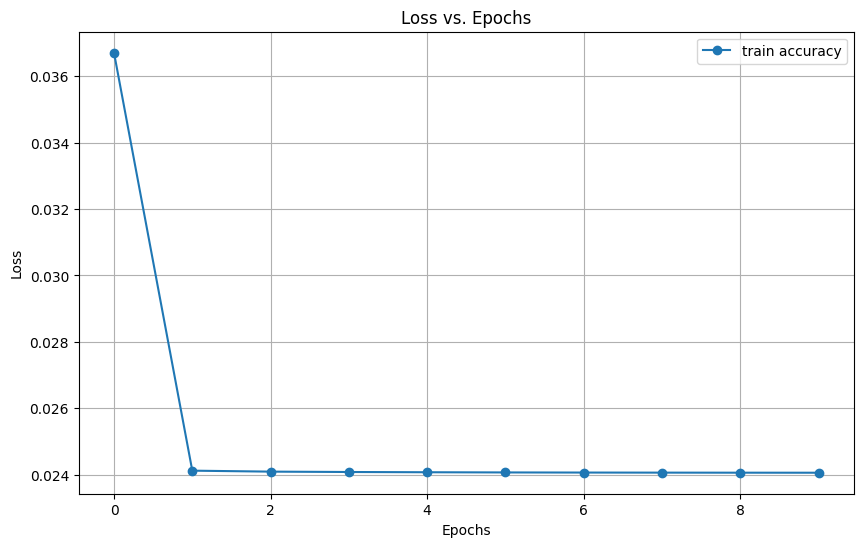

In [40]:
# plot the train and test accuracies
plt.figure(figsize=(10, 6)) 
plt.plot(range(EPOCHS), train_losses, marker='o', linestyle='-',label='train accuracy')
# plt.plot(range(EPOCHS), test_accuracies, marker='s', linestyle='--', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
y_test_pred = predict(neural_net, x_test)
print(np.mean(np.square(x_test[0] - y_test_pred[0])))

0.022323784844975155


In [42]:
print(y_test[0][0:10])
print(y_test_pred[0][0:10])

[0.50004936 0.56740819 0.37763604 0.50580017 0.3041809  0.30728483
 0.55951348 0.47860538 0.30258627 0.29829281]
[0.49668838 0.53388844 0.50311512 0.49625448 0.48442353 0.46444234
 0.46882951 0.52596284 0.50709231 0.47450306]


In [43]:
tf_neural_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_size)),
    tf.keras.layers.Dense(units=50, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=3, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=50, activation="relu"),
    tf.keras.layers.Dense(units=output_size, activation="sigmoid"),
])

tf_neural_net.compile(optimizer="sgd", loss="mse")

tf_neural_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 50)                10050     
                                                                 
 dense_15 (Dense)            (None, 10)                510       
                                                                 
 dense_16 (Dense)            (None, 3)                 33        
                                                                 
 dense_17 (Dense)            (None, 5)                 20        
                                                                 
 dense_18 (Dense)            (None, 10)                60        
                                                                 
 dense_19 (Dense)            (None, 50)                550       
                                                                 
 dense_20 (Dense)            (None, 200)              

In [44]:
history = tf_neural_net.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10
32/32 [==============================] - 1s 9ms/step - loss: 0.0290
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0288
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0286
Epoch 4/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0284
Epoch 5/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0283
Epoch 6/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0281
Epoch 7/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 8/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0279
Epoch 9/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0278
Epoch 10/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0277


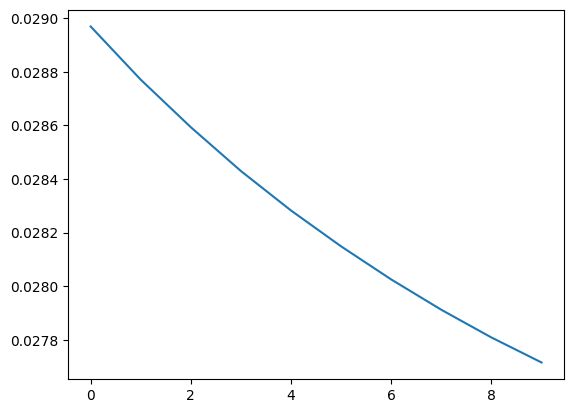

In [45]:
plt.figure()
plt.plot(history.history["loss"])

In [46]:
y_test_pred_tf = tf_neural_net.predict(x_test)
mse = tf.keras.losses.MeanSquaredError()

# print(np.linalg.norm(x_test[0] - y_test_pred_tf[0]))
print(np.mean(np.square(y_test[0] - y_test_pred_tf[0])))
print(mse(tf.expand_dims(y_test[0], axis=1), tf.expand_dims(y_test_pred_tf[0], axis=1)))

1/1 [==============================] - 0s 47ms/step
0.0260072427166833
tf.Tensor(0.026007243, shape=(), dtype=float32)


In [47]:
print(y_test[0][0:10])
print(y_test_pred_tf[0][0:10])

[0.50004936 0.56740819 0.37763604 0.50580017 0.3041809  0.30728483
 0.55951348 0.47860538 0.30258627 0.29829281]
[0.43225142 0.4039566  0.52766603 0.4995718  0.4885903  0.47499946
 0.46681055 0.49427286 0.50810254 0.5210513 ]
